In [1]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from graphviz import Digraph

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from flow import edge_credits2edge_credit
from on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution
from linear_evaluation import get_error, get_indirect_effect_flow, get_effect_asv, get_effect_ind, get_effect_manifold, get_direct_effect_flow
from linear_evaluation import get_direct_effect_ground_truth, get_indirect_effect_ground_truth

np.random.seed(42)

## Simple chain with linear model as per the paper

### Synthetic data

In [2]:
#n = 100
#x1 = np.random.randn(n)
#x2 = np.random.randn(n)
# x3 = 5*x1
# x4 = x2
# x5 = x2

x1 = [0,1]
x2 = [0,1]
x3 = map(lambda x: x * 5, x1)
x4 = map(lambda x: x, x2)
x5 = map(lambda x: x, x2)

X = pd.DataFrame.from_dict({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4, 'X5': x5}).loc[:, ['X1', 'X2', 'X3', 'X4', 'X5']]
X

,X1,X2,X3,X4,X5
0,0,0,0,0,0
1,1,1,5,1,1


y has connection to and dependent on x1, x3, x4, x5; and x2 has no direct connection with y

In [ ]:
# y = lambda x: x[:, 0] + x[:, 2] + x[:, 3]*2 + x[:, 4]*2
# y_d = pd.DataFrame.from_dict({'Y': list(y(np.array(X)))})
# pd.concat((X, y_d), 1)

### Causal graph

In [3]:
## setting up enviroment for graph viz
os.environ["PATH"] += os.pathsep + 'C:/Users/vivianjiang/anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

0it [00:00, ?it/s]


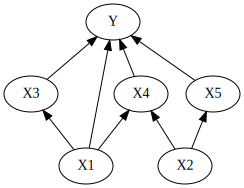

In [4]:
causal_links = CausalLinks()
target_name = 'Y'
feature_names = list(X.columns)

# build causal links
## causal_links.add_causes_effects(feature_names, target_name, lambda *args: f(np.vstack(args).T))
causal_links.add_causes_effects(['X1','X3','X4','X5'], target_name, lambda x: x)
causal_links.add_causes_effects('X1', 'X3', lambda x: x)
causal_links.add_causes_effects('X1', 'X4', lambda x: x)
causal_links.add_causes_effects('X2', 'X4', lambda x: x)
causal_links.add_causes_effects('X2', 'X5', lambda x: x)
causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, target_name=target_name)

causal_graph.draw()

### (1) Calculate overall SHAP value by feeding foreground and background sample through linear equation and calculate impact

In [5]:
background = X.iloc[[0]]
foreground = X.iloc[[1]]

y = lambda x: x[:, 0] + x[:, 2] + x[:, 3]*2 + x[:, 4]*2

y_bg = pd.DataFrame.from_dict({'Y': list(y(np.array(background)))})
y_fg = pd.DataFrame.from_dict({'Y': list(y(np.array(foreground)))})

shap_0 = y_fg-y_bg 

shap_0

,Y
0,10


### (2) Calculate contribution of super node to X1, X2

In [38]:
## Define source nodes
source_node = ['X1','X2']

In [ ]:
## Contribution of edge (0,2)
## case 1: edge (0,2) is inactive & edge (0,1) is inactive

## case 2: edge (0,2) is inactive & edge (0,1) is active

In [35]:
# Generates 2^n from elements
def powerset(elements: set):
    result = [[]]
    for a in elements:
        result += [r + [a] for r in result]
    return result

#def brute_shap(xf: list, xb: list, model: any, features: set):
def brute_shap(xf: list, xb: list, features: set):
    phi = [0] * len(features)
    for idx, feature in enumerate(features):
        
        # cause = causal.loc[causal.cause == feature, 0]
        # effect = causal.loc[causal.cause == feature, 1]
        
        for S in powerset(features.difference({feature})):
            S = set(S)
            hs = pd.DataFrame([xf[j].item() if j in S else xb[j].item() for j in features]).transpose()  # Hybrid samples
            hsi = pd.DataFrame([xf[j].item() if j in S.union({feature}) else xb[j].item() for j in features]).transpose()
            hs.columns = features
            hsi.columns = features
            #fxs = model.predict(hs).item()  # Predictions
            #fxsi = model.predict(hsi).item()
            
            y = lambda x: x[:, 0] + x[:, 2] + x[:, 3]*2 + x[:, 4]*2
            
            fxs = pd.DataFrame.from_dict({'Y': list(y(np.array(hs)))})
            fxsi = pd.DataFrame.from_dict({'Y': list(y(np.array(hsi)))})

            phi[idx] += W(len(S), len(features)) * (fxsi - fxs)  # Calculate phi contribution
            
            print(W(len(S), len(features)))
    return phi

In [39]:
print(brute_shap(foreground, background, set(source_node)))

IndexError: index 2 is out of bounds for axis 1 with size 2